In [191]:
path_to_images = "/content/drive/MyDrive/23-24-csb-ai/data/Car-Bike-Dataset"

#Load data

In [192]:
import os

os.listdir(path_to_images)

['Car', 'Bike']

In [193]:
car_data = os.path.join(path_to_images, "Car")
bike_data = os.path.join(path_to_images, "Bike")

In [194]:
car_data, bike_data

('/content/drive/MyDrive/23-24-csb-ai/data/Car-Bike-Dataset/Car',
 '/content/drive/MyDrive/23-24-csb-ai/data/Car-Bike-Dataset/Bike')

In [195]:
car_images = os.listdir(car_data)
bike_images = os.listdir(bike_data)

print(f"Available car images: {len(car_images)}.")
print(f"Available bike images: {len(bike_images)}.")

Available car images: 2000.
Available bike images: 2000.


In [196]:
car_images[:2]

['Car (408).jpeg', 'Car (375).jpeg']

In [197]:
import cv2

# declare X, y as two empty lists
X = []
y = []

# for every file in car_images
# -- load the image at that location in memory
# -- convert it to a numpy array
# -- append it to X
# -- append 0 to y
for f in car_images[:200]:
  path_to_image = os.path.join(car_data, f)
  image = cv2.imread(path_to_image)
  X.append(image)
  y.append(0)

# for every file in bike_images
# -- load the image at that location in memory
# -- convert it to a numpy array
# -- append it to X
# -- append 1 to y
for f in bike_images[:200]:
  path_to_image = os.path.join(bike_data, f)
  image = cv2.imread(path_to_image)
  X.append(image)
  y.append(1)

In [198]:
def load_images(path_to_images, label):
  image_files = os.listdir(path_to_images)

  images = []
  labels = []
  for f in image_files:
    path_to_image = os.path.join(path_to_images, f)
    image = cv2.imread(path_to_image)
    images.append(image)
    labels.append(label)

  return images, labels

#Clean data

In [199]:
import matplotlib.pyplot as plt
import numpy as np

In [200]:
# Check the loaded data
print(f"Images: {len(X)}")
print(f"Random image shape: {X[10].shape}")

Images: 400
Random image shape: (100, 100, 3)


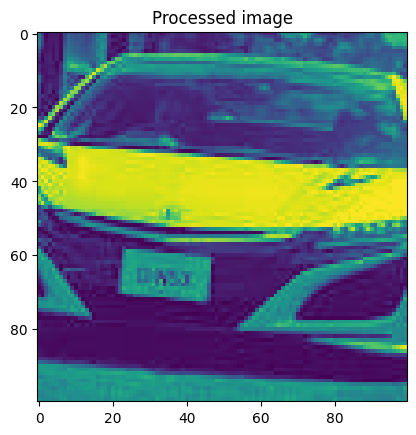

In [201]:
# 1. Normalize between 0 and 1 and reduce the colorspace to grayscale
for i in range(len(X)):
  X[i] = cv2.cvtColor(X[i].astype(np.uint8), cv2.COLOR_BGR2GRAY)
  X[i] = X[i] / 255.0

# Check the result for a number of 6 images at random (in a 3x3 grid)
# TODO: Homework

# Check the result for one image
_ = plt.figure()
plt.imshow(X[10])
plt.title("Processed image")
plt.show()

In [202]:
print(f"Image shape = {X[10].shape}")

Image shape = (100, 100)


In [203]:
# 2. Check image width and height distribution and remove very small images
widths = []
heights = []
for i in range(len(X)):
  wi = X[i].shape[1]
  hi = X[i].shape[0]
  widths.append(wi)
  heights.append(hi)

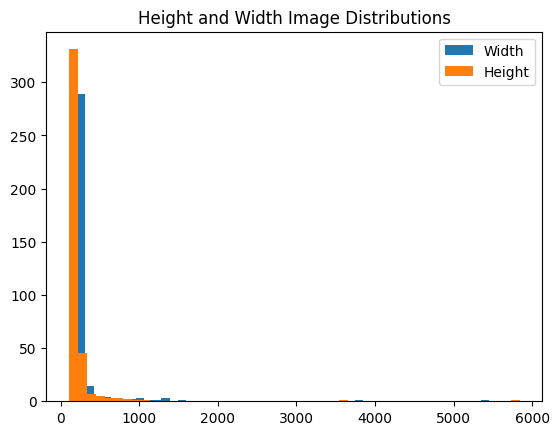

In [204]:
# Display the two distributions
_ = plt.figure()
plt.hist(widths, bins=50, label="Width")
plt.hist(heights, bins=50, label="Height")
plt.legend()
plt.title("Height and Width Image Distributions")
plt.show()

In [205]:
# 2.1. Filter very large images
w_tresh = 1000
h_tresh = 1000
X_filtered = []
y_filtered = []
for i, img in enumerate(X):
  if img.shape[0] <= h_tresh and img.shape[1] <= w_tresh:
    X_filtered.append(img)
    y_filtered.append(y[i])
print(f"Images removed: {len(X) - len(X_filtered)}")

Images removed: 9


In [206]:
# Recompute the distribution
widths = [w for w in widths if w <= w_tresh]
heights = [h for h in heights if h <= h_tresh]

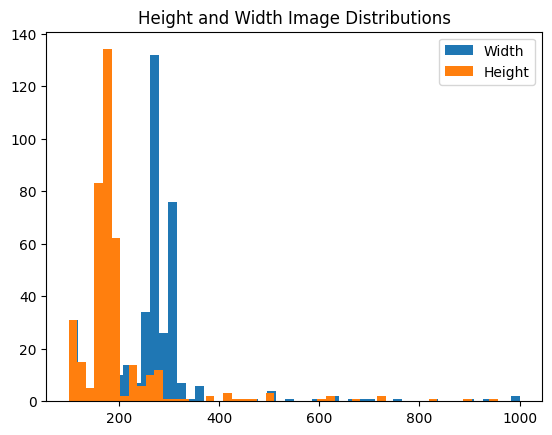

In [207]:
# Display the two distributions
_ = plt.figure()
plt.hist(widths, bins=50, label="Width")
plt.hist(heights, bins=50, label="Height")
plt.legend()
plt.title("Height and Width Image Distributions")
plt.show()

In [208]:
# 3. Standardise the images to have the same size (based on distribution computed at 2.)
w0, h0 = 50, 50
for i in range(len(X_filtered)):
  X_filtered[i] = cv2.resize(X_filtered[i], dsize=(w0, h0))

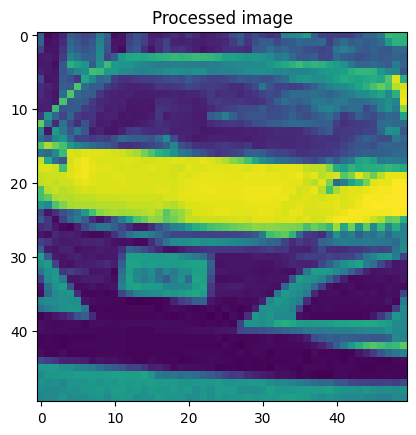

In [209]:
# Check the result for one image
_ = plt.figure()
plt.imshow(X_filtered[10])
plt.title("Processed image")
plt.show()

#Build model

In [210]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [211]:
model = Sequential([
    Conv2D(1, 3, input_shape=(h0, w0, 1)),
    # Conv2D(256, 5),
    # Conv2D(128, 5),
    # Conv2D(64, 5),
    # Conv2D(32, 5),
    # Conv2D(8, 5),
    MaxPooling2D(pool_size=2),
    # Conv2D(4, 3),
    # MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 48, 48, 1)         10        
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 1)         0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 576)               0         
                                                                 
 dense_14 (Dense)            (None, 2)                 1154      
                                                                 
Total params: 1164 (4.55 KB)
Trainable params: 1164 (4.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [212]:
model.compile(
    "adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#Train model

In [213]:
# Split data into train and test set in order to check how good is our generalisation
from sklearn.model_selection import train_test_split
X_filtered = np.array(X_filtered)
y_filtered = np.array(y_filtered)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2)
print(f"{X_train.shape=}, {X_test.shape=}")

X_train.shape=(312, 50, 50), X_test.shape=(79, 50, 50)


In [214]:
# Convert labels from scalars to vectors (using OneHot Encoding)
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
y_train[0], y_train_oh[0]

(1, array([0., 1.], dtype=float32))

In [215]:
result = model.fit(
    X_train,
    y_train_oh,
    epochs=10,
    validation_data=(X_test, y_test_oh)
)

Epoch 1/10
10/10 [==============================] - 1s 34ms/step - loss: 0.7124 - accuracy: 0.5096 - val_loss: 0.7340 - val_accuracy: 0.5316
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.5609 - val_loss: 0.7097 - val_accuracy: 0.5316
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.5737 - val_loss: 0.7219 - val_accuracy: 0.4937
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6478 - accuracy: 0.6122 - val_loss: 0.6818 - val_accuracy: 0.5316
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6301 - accuracy: 0.6410 - val_loss: 0.6803 - val_accuracy: 0.5443
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6178 - accuracy: 0.6571 - val_loss: 0.6713 - val_accuracy: 0.5443
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6064 - accuracy: 0.6538 - val_loss: 0.6739 - val_accuracy: 0.5823
Epoch 8/10
10/10 [=

In [216]:
# from google.colab import drive
# drive.mount('/content/drive')

#Analyse results

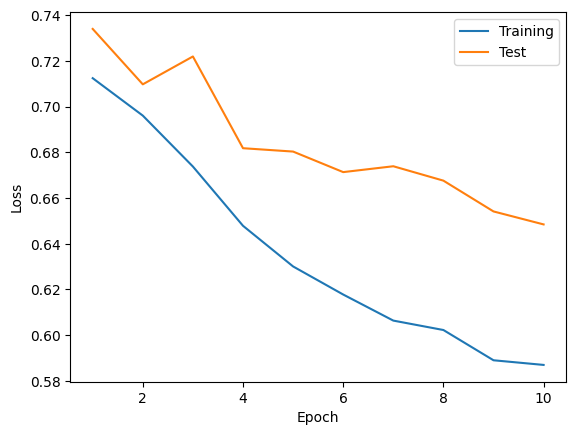

In [217]:
_ = plt.figure()
plt.plot(range(1, len(result.history["loss"])+1), result.history["loss"], label="Training")
plt.plot(range(1, len(result.history["val_loss"])+1), result.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

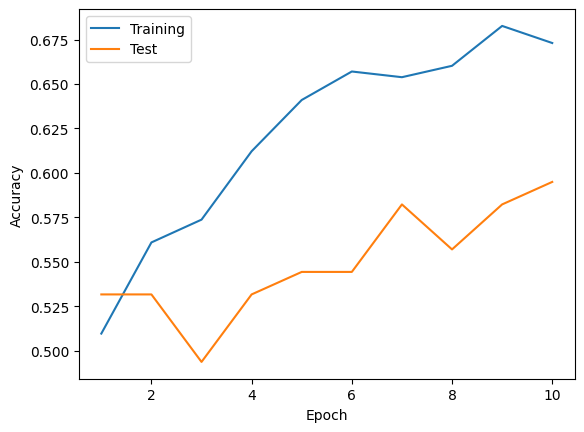

In [218]:
_ = plt.figure()
plt.plot(range(1, len(result.history["accuracy"])+1), result.history["accuracy"], label="Training")
plt.plot(range(1, len(result.history["val_accuracy"])+1), result.history["val_accuracy"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [219]:
# Predict labels and probabilities for the training data
y_train_pred = []
y_train_pred_probs = []
for xi in X_train:
  yi_probs = model.predict(np.expand_dims(xi, axis=0))[0]
  yi = np.argmax(yi_probs)
  y_train_pred.append(yi)
  y_train_pred_probs.append(yi_probs[0])

1/1 [==============================] - 0s 18ms/step


In [220]:
# Predict labels and probabilities for the test data
y_test_pred = []
y_test_pred_probs = []
for xi in X_test[:100]:
  yi_probs = model.predict(np.expand_dims(xi, axis=0))[0]
  yi = np.argmax(yi_probs)
  y_test_pred.append(yi)
  y_test_pred_probs.append(yi_probs[0])


1/1 [==============================] - 0s 17ms/step


In [221]:
# Generate confusion matrices
from sklearn.metrics import confusion_matrix
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

In [222]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_train_disp = ConfusionMatrixDisplay(cm_train, display_labels=np.unique(y_train))
cm_test_disp = ConfusionMatrixDisplay(cm_test, display_labels=np.unique(y_train))

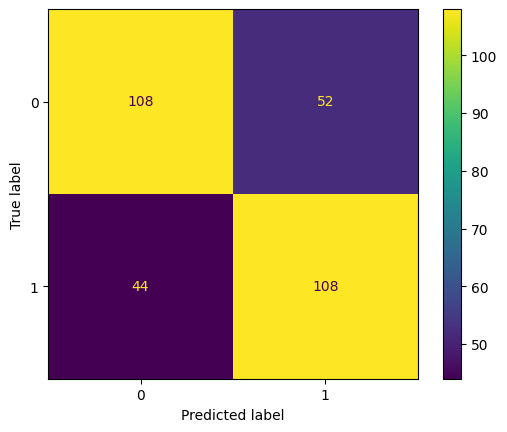

In [223]:
cm_train_disp.plot()

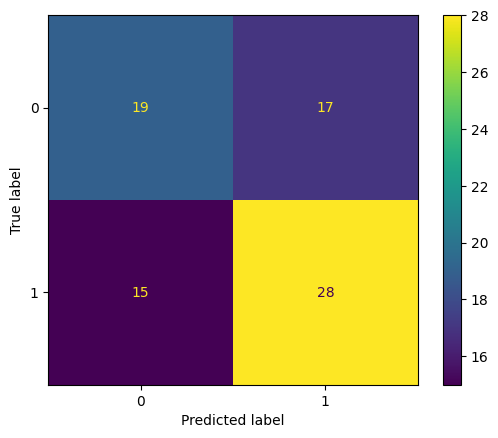

In [224]:
cm_test_disp.plot()

In [225]:
# Precision vs recall
from sklearn.metrics import precision_recall_curve

precision, recall, th = precision_recall_curve(y_train, y_train_pred)

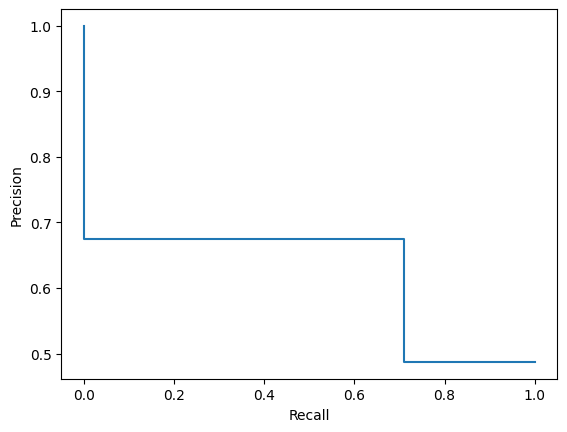

In [226]:
from sklearn.metrics import PrecisionRecallDisplay

pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.show()

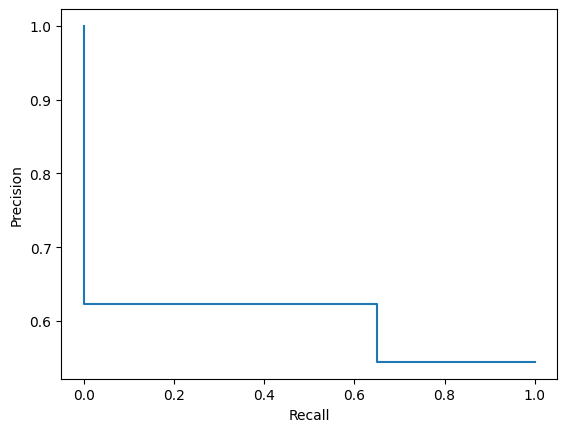

In [227]:
precision, recall, th = precision_recall_curve(y_test, y_test_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.show()

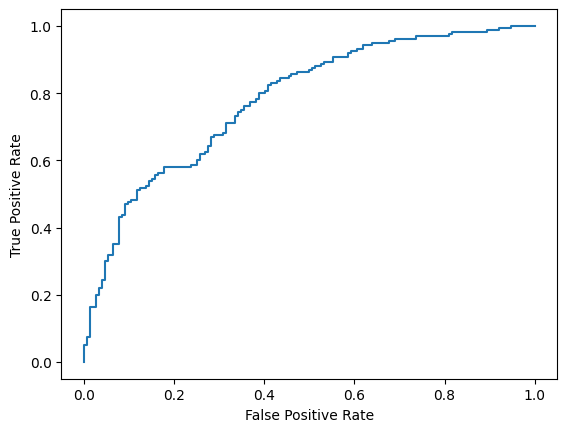

In [228]:
# AUC
from sklearn.metrics  import roc_curve, RocCurveDisplay

tpr, fpr, th = roc_curve(y_train, y_train_pred_probs)
disp = RocCurveDisplay(tpr=tpr, fpr=fpr)
disp.plot()
plt.show()

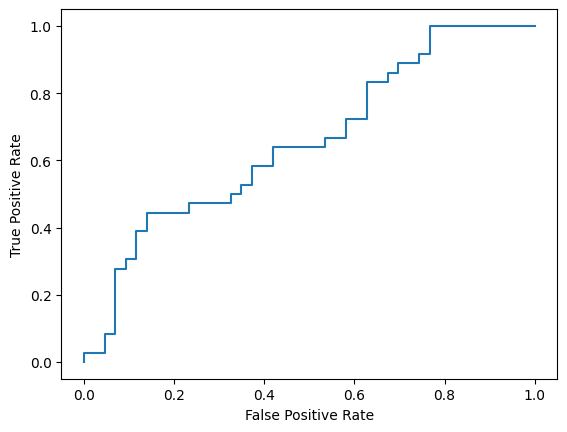

In [229]:
tpr, fpr, th = roc_curve(y_test, y_test_pred_probs)
disp = RocCurveDisplay(tpr=tpr, fpr=fpr)
disp.plot()
plt.show()

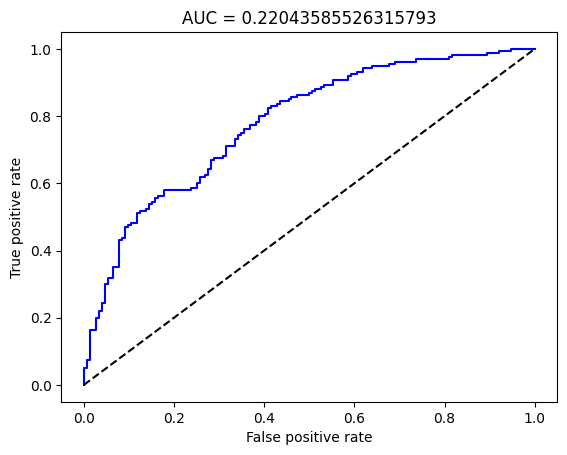

In [230]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_train, y_train_pred_probs)
tpr, fpr, th = roc_curve(y_train, y_train_pred_probs)

_ = plt.figure()
plt.plot(fpr, tpr, c='blue')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), "k--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"AUC = {auc}")
plt.show()

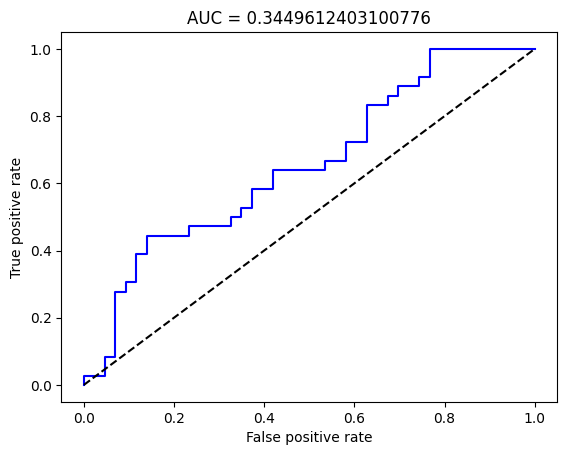

In [231]:
auc = roc_auc_score(y_test, y_test_pred_probs)
tpr, fpr, th = roc_curve(y_test, y_test_pred_probs)

_ = plt.figure()
plt.plot(fpr, tpr, c='blue')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), "k--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(f"AUC = {auc}")
plt.show()